# Libraries

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
import nltk

# Install required libraries
!pip install matplotlib nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')


In [3]:
os.makedirs('/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/models', exist_ok=True)

# EDA

In [4]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/FinalBalancedDataset.csv")

# Display dataset information and preview
data.info()
print(data.head(5))

# Drop unnecessary columns
data = data.drop("Unnamed: 0", axis=1)

# Count class distribution
print(data['Toxicity'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB
   Unnamed: 0  Toxicity                                              tweet
0           0         0   @user when a father is dysfunctional and is s...
1           1         0  @user @user thanks for #lyft credit i can't us...
2           2         0                                bihday your majesty
3           3         0  #model   i love u take with u all the time in ...
4           4         0             factsguide: society now    #motivation
Toxicity
0    32592
1    24153
Name: count, dtype: int64


# Text Preprocessing

In [5]:
# Initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def prepare_text(text):
    # Helper function to map POS tags
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    # Clean and lemmatize text
    text = re.sub(r'[^a-zA-Z\']', ' ', text)  # Remove non-alphabetic characters
    text = word_tokenize(text)
    text = pos_tag(text)
    lemma = [wordnet_lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in text]
    return ' '.join(lemma)

# Apply preprocessing
data['clean_tweets'] = data['tweet'].apply(lambda x: prepare_text(x))
print(data.head(5))


   Toxicity                                              tweet  \
0         0   @user when a father is dysfunctional and is s...   
1         0  @user @user thanks for #lyft credit i can't us...   
2         0                                bihday your majesty   
3         0  #model   i love u take with u all the time in ...   
4         0             factsguide: society now    #motivation   

                                        clean_tweets  
0  user when a father be dysfunctional and be so ...  
1  user user thanks for lyft credit i ca n't use ...  
2                                bihday your majesty  
3      model i love u take with u all the time in ur  
4                  factsguide society now motivation  


#Feature Extraction using TF-IDF

In [6]:
# Prepare the corpus
corpus = data['clean_tweets'].values.astype('U')

# Initialize TfidfVectorizer
stopwords = list(nltk_stopwords.words('english'))  # Convert set to list
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

# Transform the corpus
tf_idf = count_tf_idf.fit_transform(corpus)

# Save TF-IDF model for reuse
pickle.dump(count_tf_idf, open("/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/models/tf_idf.pkt", "wb"))


# Splitting Data into Train and Test Sets

In [7]:
# Split data into train and test sets
tf_idf_train, tf_idf_test, target_train, target_test = train_test_split(
    tf_idf, data['Toxicity'], test_size=0.8, random_state=42, shuffle=True
)


# Algorithm Implementation and Evaluation

In [8]:
# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(tf_idf_train, target_train)

    # Predict probabilities and classes
    y_pred_proba = model.predict_proba(tf_idf_test)[:, 1]
    y_pred = model.predict(tf_idf_test)

    # Calculate metrics
    roc_auc = roc_auc_score(target_test, y_pred_proba)
    accuracy = accuracy_score(target_test, y_pred)
    precision = precision_score(target_test, y_pred)
    recall = recall_score(target_test, y_pred)

    # Store the results
    results[model_name] = {
        "ROC AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

    # Display performance
    print(f"{model_name} Results:")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("-" * 50)


Naive Bayes Results:
  ROC AUC: 0.9659
  Accuracy: 0.9052
  Precision: 0.9335
  Recall: 0.8379
--------------------------------------------------
Logistic Regression Results:
  ROC AUC: 0.9716
  Accuracy: 0.9191
  Precision: 0.9573
  Recall: 0.8486
--------------------------------------------------
Random Forest Results:
  ROC AUC: 0.9732
  Accuracy: 0.9284
  Precision: 0.9420
  Recall: 0.8871
--------------------------------------------------
SVM Results:
  ROC AUC: 0.9744
  Accuracy: 0.9255
  Precision: 0.9648
  Recall: 0.8570
--------------------------------------------------


# Comparative ROC Curve Visualization

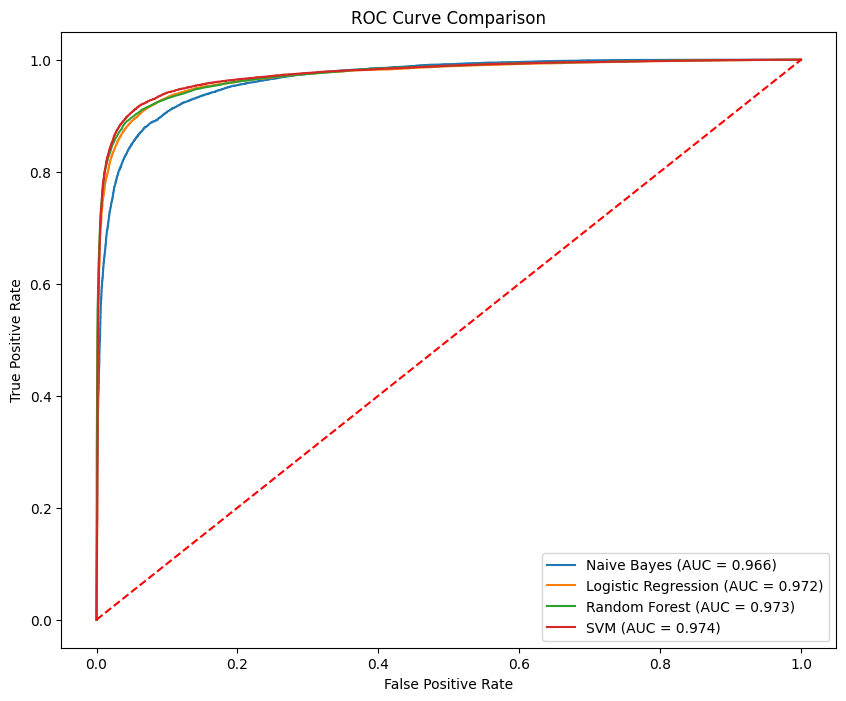

In [9]:
# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(tf_idf_test)[:, 1]
    fpr, tpr, _ = roc_curve(target_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC AUC']:.3f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="red")

# Add plot details
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# Save the Best Model

In [ ]:
# Identify the best model based on ROC AUC
best_model_name = max(results, key=lambda x: results[x]["ROC AUC"])
best_model = models[best_model_name]

# Save the best model
pickle.dump(best_model, open("/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/models/toxicity_model.pkt", "wb"))

print(f"Best Model: {best_model_name} with ROC AUC = {results[best_model_name]['ROC AUC']:.4f}")


# Testing with Custom Data

In [12]:
best_model = pickle.load(open("/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/models/toxicity_model.pkt", "rb"))
count_tf_idf = pickle.load(open("/content/drive/MyDrive/TCSC_MSC_Project/S4_Project/NLP_Project/models/tf_idf.pkt", "rb"))

# Function to preprocess and predict custom text
def predict_custom_text(custom_text):
    # Preprocess the input text (same as done in the preprocessing step)
    clean_text = prepare_text(custom_text)

    # Convert the text into TF-IDF features
    test_tfidf = count_tf_idf.transform([clean_text])

    # Make prediction (0 for Non-Toxic, 1 for Toxic)
    prediction = best_model.predict(test_tfidf)

    # Return prediction result
    return prediction[0]

# Get custom input from the user
custom_input = input("Enter a sentence to check if it is toxic or not: ")

# Get the prediction
prediction = predict_custom_text(custom_input)

# Output result
if prediction == 1:
    print("The text is predicted to be Toxic.")
else:
    print("The text is predicted to be Non-Toxic.")


Enter a sentence to check if it is toxic or not: sdfsgdbsxvfzxcyjsknmbv zbcfsgdhsdb
The text is predicted to be Non-Toxic.
